In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 시계열 데이터 처리
- 시간의 추이와 함께 순차적으로 관측한 데이터를 시계열 데이터라고 합니다.
- 시간정보를 가지는 변수가 있는지 여부
- 학습 데이터와 테스트 데이터가 시계열로 나뉘어 있는지, 시간에 따라 분할하고 검증해야 할지 여부
- 사용자나 매장등 계열별로 시계열의 목적변수가 있는지 , lag특징을 취할 수 있는 형식 이 있는지 여부

In [2]:
# 와이드 포맷의 데이터 읽기
# 인덱스의 형태를 날짜형으로 변경
data_dir = os.getenv('HOME')+'/aiffel/kaggle_study/data'
data_a= join(data_dir, 'time_series_wide.csv')

df_wide = pd.read_csv(data_a, index_col=0)
df_wide.index = pd.to_datetime(df_wide.index)


print(df_wide.iloc[:5, :3])

              A     B     C
2016-07-01  532  3314  1136
2016-07-02  798  2461  1188
2016-07-03  823  3522  1711
2016-07-04  937  5451  1977
2016-07-05  881  4729  1975


In [3]:
# 롱 포맷으로 변환
df_long = df_wide.stack().reset_index(1)
df_long.columns = ['id', 'value']

print(df_long.head(10))

           id  value
2016-07-01  A    532
2016-07-01  B   3314
2016-07-01  C   1136
2016-07-02  A    798
2016-07-02  B   2461
2016-07-02  C   1188
2016-07-03  A    823
2016-07-03  B   3522
2016-07-03  C   1711
2016-07-04  A    937


### lag 특징

In [4]:
# 와이드 포맷으로 되돌림
df_wide = df_long.pivot(index=None, columns='id', values='value')
print(df_wide)

id            A     B     C
2016-07-01  532  3314  1136
2016-07-02  798  2461  1188
2016-07-03  823  3522  1711
2016-07-04  937  5451  1977
2016-07-05  881  4729  1975
...         ...   ...   ...
2016-12-27  840  4573  1850
2016-12-28  943  4511  1764
2016-12-29  978  4599  1787
2016-12-30  907  4243  2069
2016-12-31  869  4703  2233

[184 rows x 3 columns]


In [5]:
x = df_wide
# 1일 전의 값을 획득
x_lag1 = x.shift(1)

# 7일 전의 값을 획득
x_lag7 = x.shift(7)
print(x_lag1)

id              A       B       C
2016-07-01    NaN     NaN     NaN
2016-07-02  532.0  3314.0  1136.0
2016-07-03  798.0  2461.0  1188.0
2016-07-04  823.0  3522.0  1711.0
2016-07-05  937.0  5451.0  1977.0
...           ...     ...     ...
2016-12-27  840.0  4576.0  1954.0
2016-12-28  840.0  4573.0  1850.0
2016-12-29  943.0  4511.0  1764.0
2016-12-30  978.0  4599.0  1787.0
2016-12-31  907.0  4243.0  2069.0

[184 rows x 3 columns]


In [6]:
# -----------------------------------
# shift() 함수로 각각의 날짜 데이터 값을 일정 기간 전의 데이터로 치환(여기서는 1일전)
# 첫 번째 행은 이전 날짜가 없어 NaN(빈 값)이 됨. 두 번째부터는 전날 데이터로 치환
# 변환된 데이터 기준으로 rolling() 함수를 이용. window=3(자신을 포함하여 3개 행)
# 3일 범위의 날짜 기간(자신 포함 이전 3일)의 데이터 평균을 구함. 단, NaN이 하나라도 포함되면 NaN 반환

# 1기전부터 3기간의 이동평균 산출
x_avg3 = x.shift(1).rolling(window=3).mean()
print(x_avg3)

id                   A            B            C
2016-07-01         NaN          NaN          NaN
2016-07-02         NaN          NaN          NaN
2016-07-03         NaN          NaN          NaN
2016-07-04  717.666667  3099.000000  1345.000000
2016-07-05  852.666667  3811.333333  1625.333333
...                ...          ...          ...
2016-12-27  817.333333  4956.000000  1976.666667
2016-12-28  797.333333  4726.000000  1878.666667
2016-12-29  874.333333  4553.333333  1856.000000
2016-12-30  920.333333  4561.000000  1800.333333
2016-12-31  942.666667  4451.000000  1873.333333

[184 rows x 3 columns]


In [7]:
# 모든 날짜를 1일 이전 데이터로 치환한 뒤,
# 변환된 데이터의 지정 시점부터 이전 날짜의 7일간의 범위에서 최댓값을 산출
x_max7 = x.shift(1).rolling(window=7).max()
print(x_max7)

id              A       B       C
2016-07-01    NaN     NaN     NaN
2016-07-02    NaN     NaN     NaN
2016-07-03    NaN     NaN     NaN
2016-07-04    NaN     NaN     NaN
2016-07-05    NaN     NaN     NaN
...           ...     ...     ...
2016-12-27  992.0  5263.0  2226.0
2016-12-28  992.0  5263.0  2226.0
2016-12-29  992.0  5263.0  2181.0
2016-12-30  978.0  5263.0  2144.0
2016-12-31  978.0  5263.0  2144.0

[184 rows x 3 columns]


## 시점 관련 특징 생성

In [8]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_study/data'
data_a= join(data_dir, 'time_series_train.csv')
data_b= join(data_dir, 'time_series_events.csv')


train_x = pd.read_csv(data_a)
event_history = pd.read_csv(data_b)
train_x['date'] = pd.to_datetime(train_x['date'])
event_history['date'] = pd.to_datetime(event_history['date'])



print(train_x)

       user_id       date  target
0            1 2018-01-01       1
1            1 2018-01-02       1
2            1 2018-01-03       1
3            1 2018-01-04       1
4            1 2018-01-05       0
...        ...        ...     ...
36495      100 2018-12-27       0
36496      100 2018-12-28       1
36497      100 2018-12-29       1
36498      100 2018-12-30       1
36499      100 2018-12-31       1

[36500 rows x 3 columns]


In [9]:
# train_x는 학습 데이터로 사용자 ID, 날짜를 열로 갖는 데이터 프레임
# event_history는 과거에 개최한 이벤트의 정보로 날짜, 이벤트를 열로 가진 데이터 프레임
# occurrences는 날짜, 세일 개최 여부를 열로 가진 DataFrame이 됨
dates = np.sort(train_x['date'].unique())
occurrences = pd.DataFrame(dates, columns=['date'])
sale_history = event_history[event_history['event'] == 'sale']
occurrences['sale'] = occurrences['date'].isin(sale_history['date'])

In [10]:

# 누적합을 얻어 각 날짜별 누적 출현 횟수를 표시
# occurrences는 날짜, 세일 누적 출현 횟수를 열로 갖는 데이터 프레임이 됨
occurrences['sale'] = occurrences['sale'].cumsum()
print(train_x)

       user_id       date  target
0            1 2018-01-01       1
1            1 2018-01-02       1
2            1 2018-01-03       1
3            1 2018-01-04       1
4            1 2018-01-05       0
...        ...        ...     ...
36495      100 2018-12-27       0
36496      100 2018-12-28       1
36497      100 2018-12-29       1
36498      100 2018-12-30       1
36499      100 2018-12-31       1

[36500 rows x 3 columns]


In [11]:
# 날짜를 기준으로 학습 데이터와 결합
train_x = train_x.merge(occurrences, on='date', how='left')
print(train_x)

       user_id       date  target  sale
0            1 2018-01-01       1     0
1            1 2018-01-02       1     0
2            1 2018-01-03       1     1
3            1 2018-01-04       1     1
4            1 2018-01-05       0     1
...        ...        ...     ...   ...
36495      100 2018-12-27       0     4
36496      100 2018-12-28       1     4
36497      100 2018-12-29       1     4
36498      100 2018-12-30       1     5
36499      100 2018-12-31       1     5

[36500 rows x 4 columns]


In [12]:
# train_x는 학습 데이터, train_y는 목적 변수, test_x는 테스트 데이터
# pandas의 DataFrame, Series의 자료형 사용(numpy의 array로 값을 저장하기도 함.)

data_dir = os.getenv('HOME')+'/aiffel/kaggle_study/data'
data_a= join(data_dir, 'train_preprocessed_onehot.csv')
data_b= join(data_dir, 'test_preprocessed_onehot.csv')


train1 = pd.read_csv(data_a)
test_x = pd.read_csv(data_b)


train_x = train1.drop(['target'], axis=1)
train_y = train1['target']
print(train_y)

0       0
1       0
2       1
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: target, Length: 10000, dtype: int64


In [13]:
train_x_saved = train_x.copy()
test_x_saved = test_x.copy()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 표준화한 학습 데이터와 테스트 데이터를 반환하는 함수
def load_standarized_data():
    train_x, test_x = train_x_saved.copy(), test_x_saved.copy()

    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    return pd.DataFrame(train_x), pd.DataFrame(test_x)


In [15]:
# MinMax 스케일링을 수행한 학습 데이터와 테스트 데이터를 반환하는 함수
def load_minmax_scaled_data():
    train_x, test_x = train_x_saved.copy(), test_x_saved.copy()

    # Min-Max Scaling 진행
    scaler = MinMaxScaler()
    scaler.fit(pd.concat([train_x, test_x], axis=0))
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    return pd.DataFrame(train_x), pd.DataFrame(test_x)

In [16]:
# -----------------------------------
# PCA
# -----------------------------------
# 표준화된 데이터를 사용
train_x, test_x = load_standarized_data()
# -----------------------------------
# PCA
from sklearn.decomposition import PCA

# 데이터는 표준화 등의 스케일을 갖추기 위한 전처리가 이루어져야 함

# 학습 데이터를 기반으로 PCA에 의한 변환을 정의
pca = PCA(n_components=5)
pca.fit(train_x)

# 변환 적용
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# -----------------------------------
# 표준화된 데이터를 사용
train_x, test_x = load_standarized_data()
# -----------------------------------
# TruncatedSVD
from sklearn.decomposition import TruncatedSVD

# 데이터는 표준화 등의 스케일을 갖추기 위한 전처리가 이루어져야 함

# 학습 데이터를 기반으로 SVD를 통한 변환 정의
svd = TruncatedSVD(n_components=5, random_state=71)
svd.fit(train_x)

# 변환 적용
train_x = svd.transform(train_x)
test_x = svd.transform(test_x)
print(test_x)

[[-0.16004633 -3.82416435 -0.15731164  1.20833957  1.4972762 ]
 [-0.23103894 -2.11872676  1.86128095 -1.3459273   0.09233595]
 [ 0.974072    1.68315017 -0.37375423 -0.99856532  0.86052475]
 ...
 [ 0.93093381 -2.45541279 -1.45494386  1.09200355 -2.20319345]
 [ 1.15639995  0.06341051 -0.97224042  1.24802647 -2.2747641 ]
 [-1.98546106  0.50331877 -0.23141139 -1.51856784  1.07470043]]


In [17]:
# -----------------------------------
# NMF
# -----------------------------------
# 비음수의 값이기 때문에 MinMax스케일링을 수행한 데이터를 이용
train_x, test_x = load_minmax_scaled_data()
# -----------------------------------
from sklearn.decomposition import NMF

# 데이터는 음수가 아닌 값으로 구성

# 학습 데이터를 기반으로 NMF에 의한 변환 정의
model = NMF(n_components=5, init='random', random_state=71)
model.fit(train_x)

# 변환 적용
train_x = model.transform(train_x)
test_x = model.transform(test_x)

In [18]:
# -----------------------------------
# LatentDirichletAllocation
# -----------------------------------
# MinMax스케일링을 수행한 데이터를 이용
# 카운트 행렬은 아니지만, 음수가 아닌 값이면 계산 가능
train_x, test_x = load_minmax_scaled_data()
# -----------------------------------
from sklearn.decomposition import LatentDirichletAllocation

# 데이터는 단어-문서의 카운트 행렬 등으로 함

# 학습 데이터를 기반으로 LDA에 의한 변환을 정의
model = LatentDirichletAllocation(n_components=5, random_state=71)
model.fit(train_x)

# 변환 적용
train_x = model.transform(train_x)
test_x = model.transform(test_x)
print(test_x)

[[0.50195545 0.01122961 0.01126158 0.01132943 0.46422393]
 [0.01263978 0.01264373 0.94924557 0.01278383 0.0126871 ]
 [0.01406492 0.94370447 0.01407466 0.01403559 0.01412036]
 ...
 [0.01225082 0.01226618 0.01225357 0.95097413 0.0122553 ]
 [0.01327285 0.01323871 0.01326013 0.42427396 0.53595436]
 [0.0129966  0.16036495 0.01299578 0.01302229 0.80062039]]


### T-SNE

따라서 독립변수는 입력값이나 원인을 나타내며, 종속변수는 결과물이나 효과를 나타낸다. 기타 여러 가지 원인으로 관찰 중인 변수들은 기타 변수라고 한다

독립변수들을 모두 사용하면 변수들간의 관계로 인해 어려워진다. 그러므로 변수들을 분석을 해야 하는데 
종류에는 주성분분석, 군집분석등이 있다.
주성분분석이란. 데이터를 분석할 때 변수의 개수가 많다고 모두 활용하는 것이 꼭 좋은 것은 아님
오히려 변수가 다중공선성이 있을 경우 분석 결과에 영향을 줄 수도 있음, 공분산행렬 또는 상관계수 행렬을 사용해 모든 변수들을 가장 잘 설명하는 주성분을 찾는 방법이다. 상관관계가 있는 변수들을 선형 결합에 의해 상관관계가 없는 새로운 변수를 만들고 분산을 극대화하는 변수로 축약함
주성분(관계가 없는것, 축을 회전하여 직교하는 성분으로 변환하는것이 선형결합)_은 변수들의 선형결합으로 이루어져 있음


차원축소는 상관관계가 중요하다 ex) 고전,국어,프랑스어와 언어지능과 상관관계가 있는가 
 = 상관관계가 높은 변수들을 묶어?보자
관측이 불가능한 보이지 않는 대상을 측정하기 위해 관측이 가능한 보이는 것을 이용해 심리학 등의 연구가 가능함
너무 많은 변수를 줄여주어 보다 적은 변수로도 원하는 대상을 측정할 수 있도록 함

단점: 정보의 손실이 발생, 분산을 버리는 경우도 있다. 직관적으로 이해를 하지 못 할경우도 많다

### t-SNE Visualizing Data using t-SNE 데이터 시각화
- 고차원 데이터를 탐색하는 인기 있는 방법은 t-SNE라고 하는 것입니다. 2008년 반 데르 마텐과 힌튼 [1]. 이 기술은 수백 또는 수천 차원의 데이터에서 매력적인 2차원 "지도"를 생성하는 거의 마법 같은 능력을 가지고 있기 때문에 기계 학습 분야에서 널리 보급되었습니다

- 주성분 분석과 비교해 클래스별 비선형적 특징을 파악하여 더 명확하게 클래스를 분리했습니다.


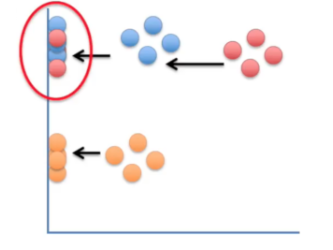

PCA을 이용하여 차원을 감소시킬려고 하였을때 데이터들이 뭉게져서 제대로 구별할 수 없는 문제를 가지고 있음
위와 같이 2차원에서는 파란색과 붉은색이 구별이 되는데, 1차원으로 줄면서 1차원상의 위치가 유사한 바람에, 두 군집의 변별력이 사라짐

그러나 데이타의 군집성과 같은 특성들은 유지 되기 때문에 시각화를 통한 데이타 분석에는 유용하지만, 매번 값이 바뀌는 특성으로 인하여, 머신러닝 모델의 학습 피쳐로 사용하기는 다소 어려운점이 있다.



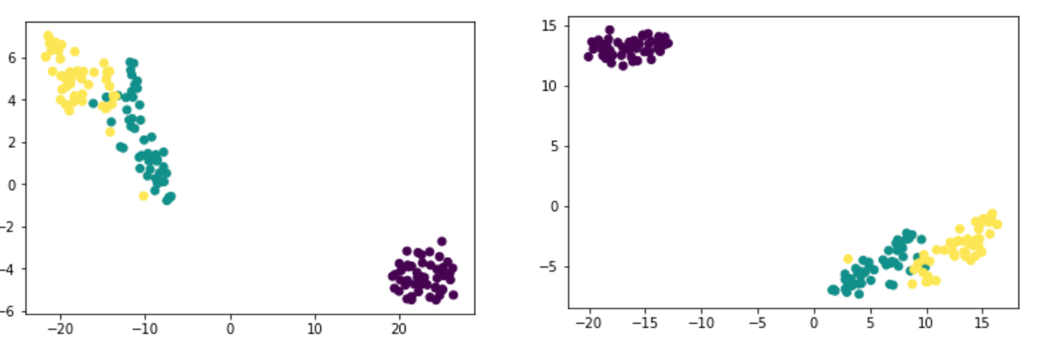

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import bhtsne

# 데이터는 표준화 등의 스케일을 갖추기 위한 전처리가 이루어져야 함

# t-sne에 의한 변환
data = pd.concat([train_x, test_x])
embedded = bhtsne.tsne(data.astype(np.float64), dimensions=2, rand_seed=71)

# 모듈을 설치해도 커널 재생성으로 말짱도루묵

ModuleNotFoundError: No module named 'bhtsne'

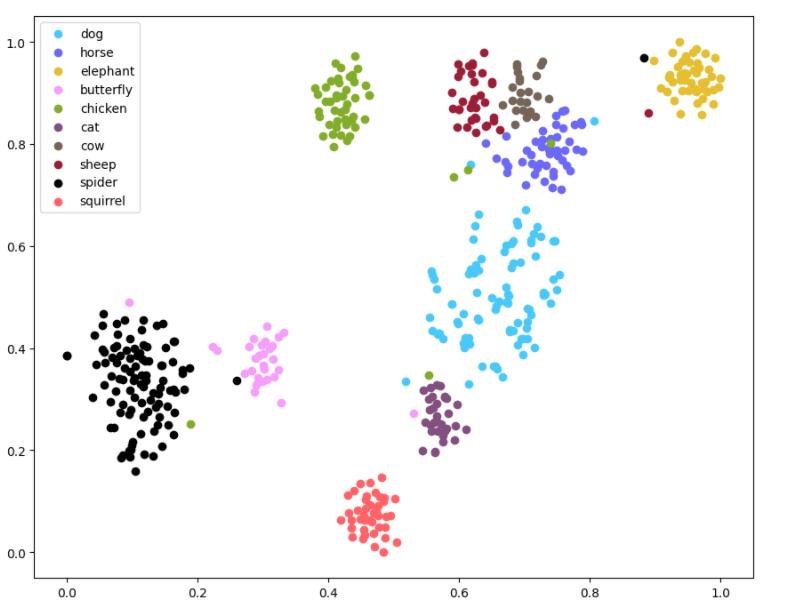

## UMAP
- 차원 축소를 위한 새로운 다양체 학습 기법입니다. UMAP은 리만 기하학과 대수 토폴로지를 기반으로 하는 이론적 프레임워크에서 구성됩니다. 결과는 실제 데이터에 적용되는 실용적인 확장 가능한 알고리즘입니다. UMAP 알고리즘은 시각화 품질 면에서 t-SNE와 경쟁력이 있으며 뛰어난 런타임 성능으로 글로벌 구조를 더 많이 보존합니다. 또한 UMAP은 차원 삽입에 대한 계산적 제한이 없으므로 기계 학습을 위한 범용 차원 축소 기술로 실행 가능합니다.

#### umap인 tnse와는 달리 euclidean distance 를 쓰지 않고 고차원에서 지수 확률 분포를 사용 그리고 어떠한 거리도 다 연결해서 사용할 수 있다. 게다가 확률도 노말라이즈를 할 필요 없음

-  normalization의 부재는 고차원 그래프에서 계산 시간을 줄여줄 수 있다. 
- UMAP은 TSNE과는 다르게 Cross Entropy를 사용한다고 함. 저 식에서 2번째 텀이 왜 UMAP이 Global data structure를 잘 캐치하게 되는지에 대해서 보여주겠다고 함. (지역 구조를 중간 정도의 난해한 값으로 모델링할 수 있는 tSNE와는 대조적이다.) 



In [24]:
import umap

# 데이터는 표준화 등의 스케일을 갖추는 전처리가 이루어져야 함

# 학습 데이터를 기반으로 UMAP에 의한 변환을 정의
um = umap.UMAP()
um.fit(train_x)

# 변환 적용
train_x = um.transform(train_x)
test_x = um.transform(test_x)


ModuleNotFoundError: No module named 'umap'

## 오토인코더
- 오토인코더(Autoencoder)는 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경망이다. 어떻게 보면 간단한 신경망처럼 보이지만 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망으로 만든다. 예를들어 아래 그림처럼 hidden layer의 뉴런 수를 input layer(입력층) 보다 작게해서 데이터를 압축(차원을 축소)한다거나, 입력 데이터에 노이즈(noise)를 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 학습시키는 등 다양한 오토인코더가 있다. 이러한 제약들은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 방지하며, 데이터를 효율적으로 표현(representation)하는 방법을 학습하도록 제어한다.



- 위 그림의 오토인토더는 히든 레이어의 뉴런(노드, 유닛)이 입력층보다 작으므로 입력이 저차원으로 표현되는데, 이러한 오토인코더를 Undercomplete Autoencoder라고 한다. undercomplete 오토인코더는 저차원을 가지는 히든 레이어에 의해 입력을 그대로 출력으로 복사할 수 없기 때문에, 출력이 입력과 같은 것을 출력하기 위해 학습해야 한다. 이러한 학습을 통해 undercomplete 오토인코더는 입력 데이터에서 가장 중요한 특성(feature)을 학습하도록 만든다.



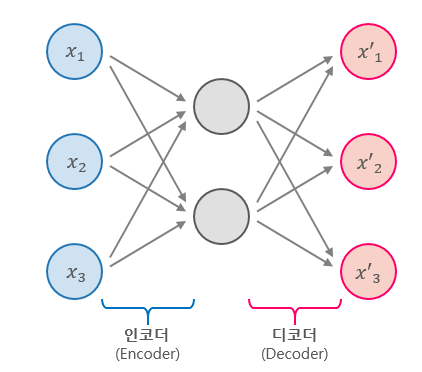


## 언제 오토인코더를 사용할까?


- AutoEncoder는 실제로 InputData의 Feature를 추출할 때 많이 사용합니다.
- 오토 인코더의 특징으로는 적어도 입력값에 대해서는 복원을 잘한다.


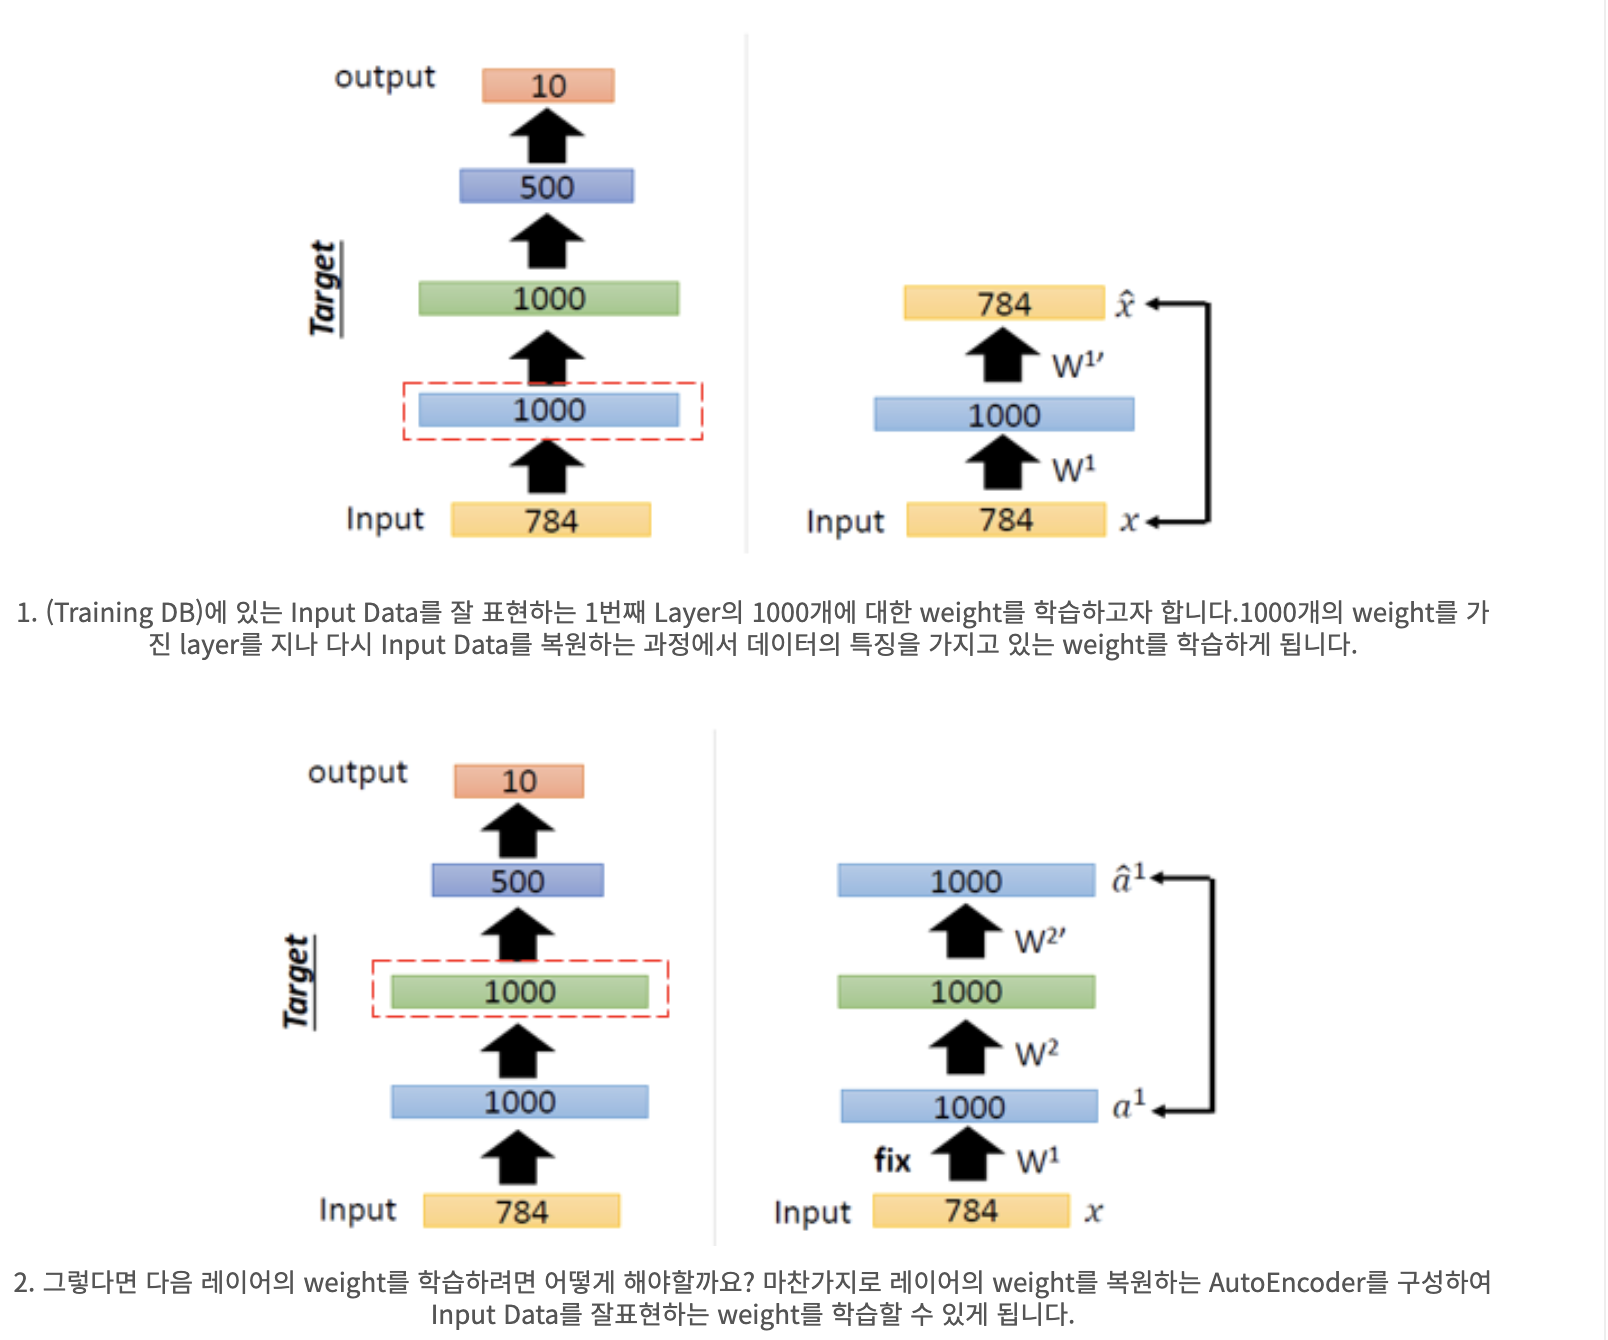

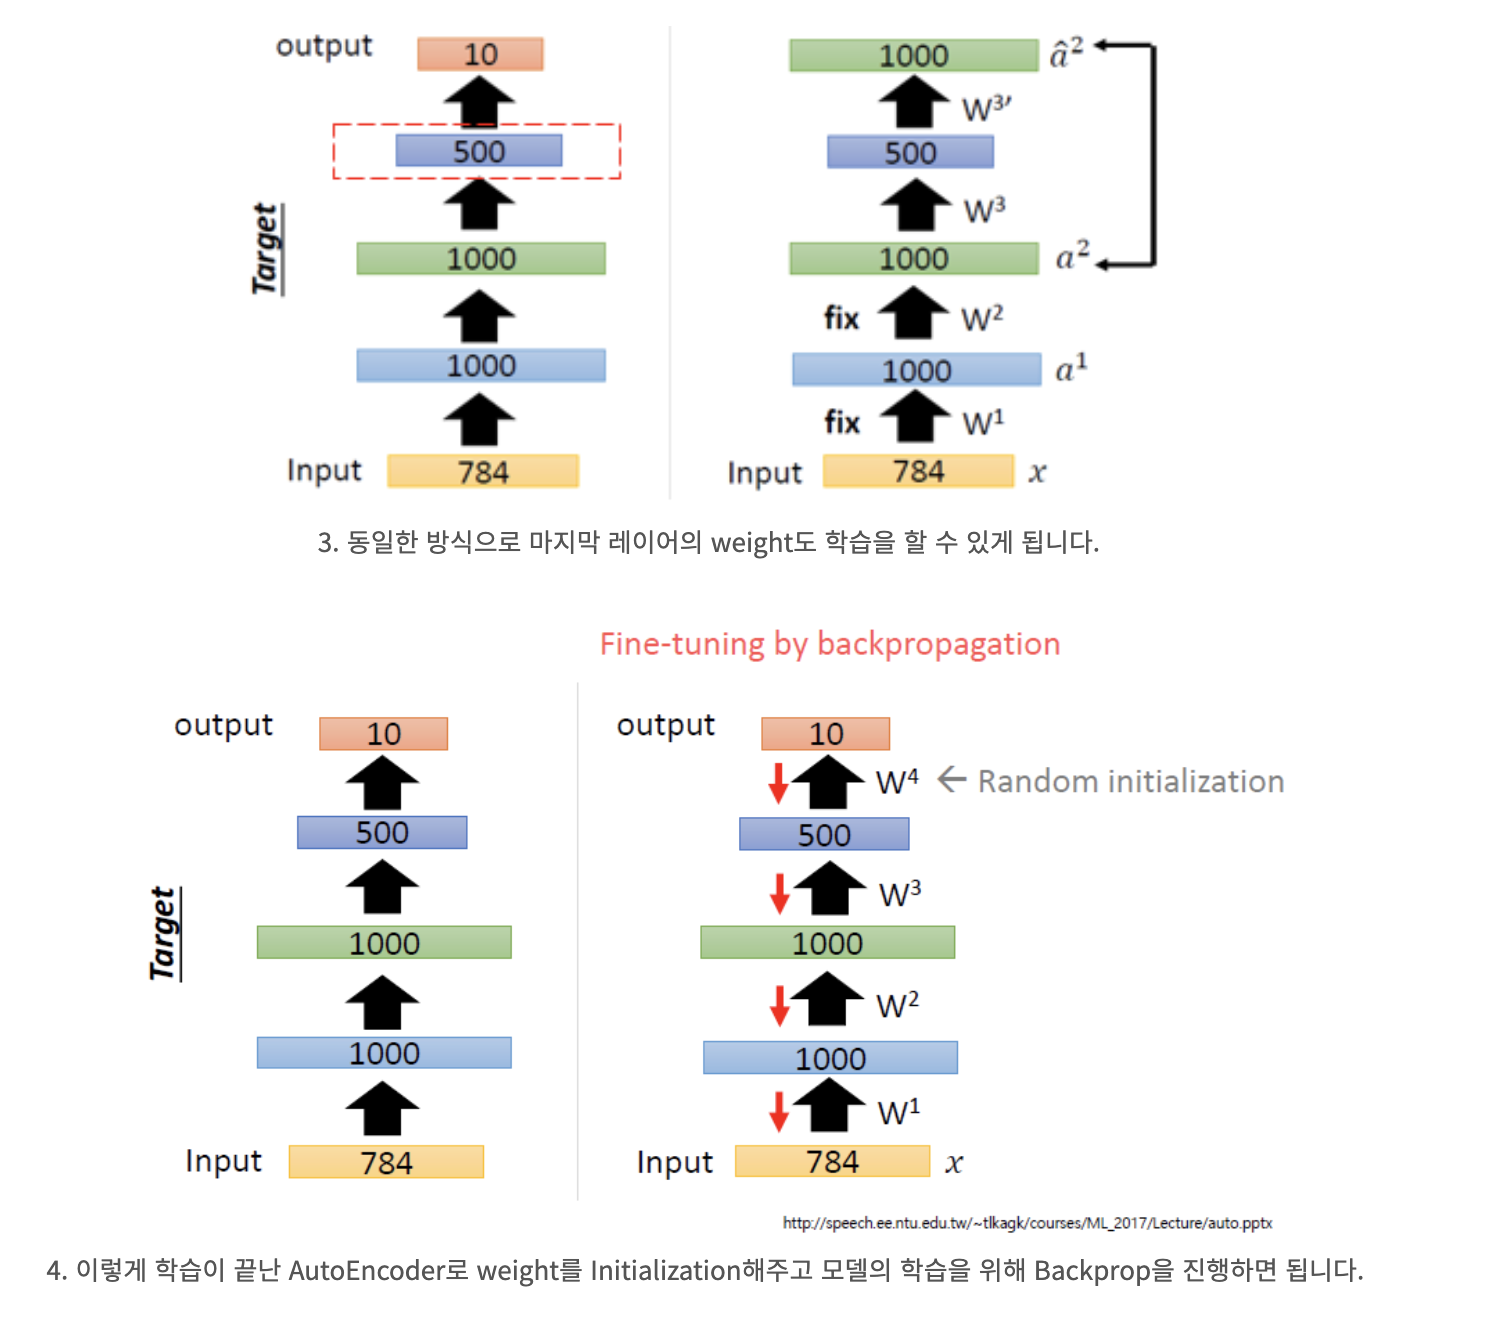

### 군집화

- 클러스터링이라고도 부르는 군집화는 데이터를 여러 그룹으로 나누는 비지도 학습입니다.
- 비지도학습의 대표적인 기술로 x에대한 레이블이 지정 되어있지 않은 데이터를 그룹핑하는 분석 알고리즘
- 데이터들의 특성을 고려해 데이터 집단(클러스터)을 정의하고 데이터 집단의 대표할 수 있는 중심점을 찾는 것으로 데이터 마이닝의 한 방법이다.
- 클러스터란 비슷한 특성을 가진 데이터들의 집단이다. 반대로 데이터의 특성이 다르면 다른 클러스터에 속해야 한다. 


(속성의 개수가 많으면 군집화 하기 어려워짐)
https://bangu4.tistory.com/98

In [25]:
from sklearn.cluster import MiniBatchKMeans

# 데이터는 표준화 등의 스케일을 갖추는 전처리가 이루어져야 함
# 클러스터링 : 데이터를 가각의 군집으로 묶어서, 같은 군집의 요소들은 서로 비슷하도록, 다른 군집에 속한 것들은 달라지도록 하여 자연스러운 그룹을 찾는 기법
# 학습 데이터를 기반으로 Mini-Batch K-Means를 통한 변환 정의
kmeans = MiniBatchKMeans(n_clusters=10, random_state=71)  # 형성할 클러스터의 수와 생성할 중심의 수입니다.


kmeans.fit(train_x)

# 해당 클러스터를 예측
train_clusters = kmeans.predict(train_x)
test_clusters = kmeans.predict(test_x)

# 각 클러스터 중심까지의 거리를 저장
train_distances = kmeans.transform(train_x)
test_distances = kmeans.transform(test_x)


In [26]:
print(test_distances)

[[0.61836128 0.82563551 0.53358049 ... 0.92627579 0.0569917  0.63339647]
 [1.24827285 0.49009838 1.11510288 ... 0.6497253  1.13440504 0.73875183]
 [1.19513221 0.87712496 0.97801769 ... 1.12841934 1.1266084  1.12486333]
 ...
 [1.21474976 1.11869105 0.90324502 ... 0.67666467 1.14112787 1.13974047]
 [0.47582928 0.90077677 0.78903053 ... 0.69936011 0.60375527 0.57375087]
 [0.10207142 0.96800825 0.98467638 ... 1.02693209 0.55607385 0.50736743]]


In [27]:
print(test_clusters)

[8 6 4 ... 3 0 0]


### 기타 기법

### 사용자 행동에 주목
분석 대상 데이터에 관한 배경 지식을 사용하여 유효한 특징부터 만들어가는게 효율적

- 개인에게 초점을 두어 사용자의 선호도 특징을 알아 볼 수 있다.

ex) 특징을 이용하여 다가올 가을에 어떤 옷이 많이 판매가 될지 예측가능

### 서비스 제공 측의 동향 주목

서비스를 제공하는 측의 움직임에 주목

- 서비스를 제공하는 입장이 되어 어떤 데이터가 특징이 될 수 있는지 또 어떤 동향을 보이는지 알 수 있다.

ex) 옷사이트의 점검으로 인해 얼마나 수익률이 감소 되었고, 22시에 구매율이 가장 높고, 오전 2시에 구매율이 가장 떨어지므로 점검을 진행한다. 점검대비 수익률을 파악

### 업계에서 주로 사용하는 분석 방법

업계에서 일반적으로 사용하는 분석을 찾아보자

- 파이썬을 이용하여 RFM을 사용함. (RFM분석 고객 분석 기법을 이용하여 사용자 분류와 특징을 생성신 구매일, 구매빈도, 구매금액 을 이용하여 고객에게 가중치를 부여함)





### 행 데이터의 관계성에 주목

- 독립적인 데이터가 있는 반면, 행 데이터끼리 일부 강한 관계성을 지니는 데이터도 있습니다. 
- 관계성 파악하는게 중요하며 , 패턴을 파악하는게 중요 ( 곧 데이터의 정보를 미리 확인하는 연습이 필요해 보임)


ex) house price 예측 캐글 대회에서 위치,면적,화장실 갯수등은 매우 집가격 예측하는 목적변수와 관련이 있지만 집 전화번호, 몇명이 거주하는지는 가격 예측에 크게 관련이 없다.

### 사용값에 주목

- 다른 값과 비교했을 때의 차이나 비율과 같은 상댓값에 주목하는 것도 효과적입니다. 

변수들 간의 평균과 차이를 이용하여 해당하는 변수를 예측해 볼 수 있다.


ex) 사용자와 같은 직업군을 가진 사람들은 한달에 옷 구매금액을 예측

### 위치 정보에 주목

- 위도나 경도 등의 우치 정보가 데이터에 포함될 경우 위치 간 거리를 특징으로 고려

ex ) 해당하는 매장의 위도나 경도를 파악하여 지하철 역과 멀어 질 수록 얼마나 수익률이 떨어지는지 예측